# Imports

In [12]:
%load_ext zipline
import numpy as np
import pandas as pd
import builtins
import pyfolio as pf
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
# import pyfolio as pf
# from pyfolio.utils import extract_rets_pos_txn_from_zipline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


# Performance Functions

In [13]:
def rolling_sharpe(ret):
    return np.multiply(np.divide(ret.mean(), ret.std()), np.sqrt(252))

def get_rolling_stats(result, r_window):
    result["rolling_sharpe"] = result["portfolio_value"].pct_change().rolling(r_window).apply(rolling_sharpe)
    result["rolling_vol"] = result["portfolio_value"].pct_change().rolling(r_window).std()
    stats = [result.rolling_sharpe.mean(), result.portfolio_value.mean(), result.rolling_vol.mean()]
    return result, stats

def show_rolling_stats(result, r_window):
    result, stats = get_rolling_stats(result, r_window)
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    result['rolling_sharpe'].plot(ax = ax[0], title='Rolling sharpe')
    result['rolling_vol'].plot(ax = ax[1], title='Rolling vol')
    result['portfolio_value'].plot(ax = ax[2], title='Portfolio value')
    plt.show()
    return result

# Check Bundels

In [14]:
!zipline bundles

Korea_commodity 2023-12-07 06:43:39.074692
Singapore_commodity 2023-12-07 06:55:23.009747
cryptocompare_daily <no ingestions>
csvdir <no ingestions>
dsebundle <no ingestions>
quandl 2023-12-05 15:08:06.923770
quantopian-quandl <no ingestions>
snp100bundles 2023-12-14 07:22:28.451665


# Initialize Variables

In [15]:
# Set the start and end dates
start_date = pd.Timestamp('2010-01-01')
end_date = pd.Timestamp('2021-07-31')
capital_base = 10_000
# calendar = get_calendar('XDSE')
symb = 'AAPL'
bollinger_window = 30
bollinger_dev = 2

# ZipLine Functions

In [16]:
def initialize(context):
    context.i = 0
    context.asset = symbol(symb)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands

def handle_data(context, data):
    context.i += 1
    if context.i < context.bollinger_window:
        return
    buy_signal = False
    sell_signal = False
    # Get historical price data
    prices = data.history(context.asset, 'close', context.bollinger_window + 1, frequency='1d')
    # print(prices)
    # Calculate Bollinger Bands
    sma = prices.mean()
    rolling_std = prices.std()
    upper_band = sma + (context.bollinger_dev * rolling_std)
    lower_band = sma - (context.bollinger_dev * rolling_std)

    # Get the current price
    current_price = data.current(context.asset, 'close')

    # Generate signals based on Bollinger Bands
    if current_price > upper_band:
        order_target_percent(context.asset, -0.5)  # Short position
        buy_signal=True
    elif current_price < lower_band:
        order_target_percent(context.asset, 0.5)  # Long position
        sell_signal=True
    else:
        order_target_percent(context.asset, 0)  # Close position

    # Record the values for later analysis
    record(price=current_price, upper=upper_band, lower=lower_band)
    record(
        AAPL=current_price,
        lower_band=lower_band, upper_band=upper_band,
        sell_signal = sell_signal,
        buy_signal = buy_signal,
        price_hist=prices
    )

In [17]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='snp100bundles',
)

/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


# Volitility, Sharpe Ratio and Portfolio Value Chart

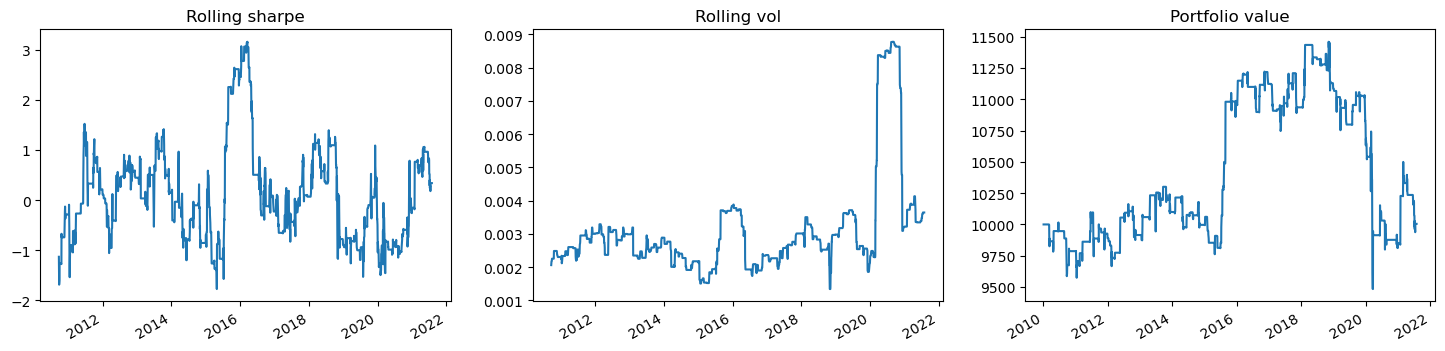

In [18]:
result = show_rolling_stats(result, 180)

# Tear Sheet

/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.004%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2010-01-04
End date,2021-07-30
Total months,138
,Backtest
Annual return,0.004%
Cumulative returns,0.047%
Annual volatility,5.423%
Sharpe ratio,0.03
Calmar ratio,0.00
Stability,0.28
Max drawdown,-17.245%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.24,2018-11-07,2020-03-23,NaT,NaN
1,5.23,2013-10-21,2015-04-27,2015-08-05,468
2,4.41,2010-06-21,2011-01-14,2011-06-21,262
3,4.28,2011-06-21,2012-02-14,2012-08-21,306
4,4.23,2016-11-10,2017-05-12,2018-02-06,324


/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:1373: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(
/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:1401: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


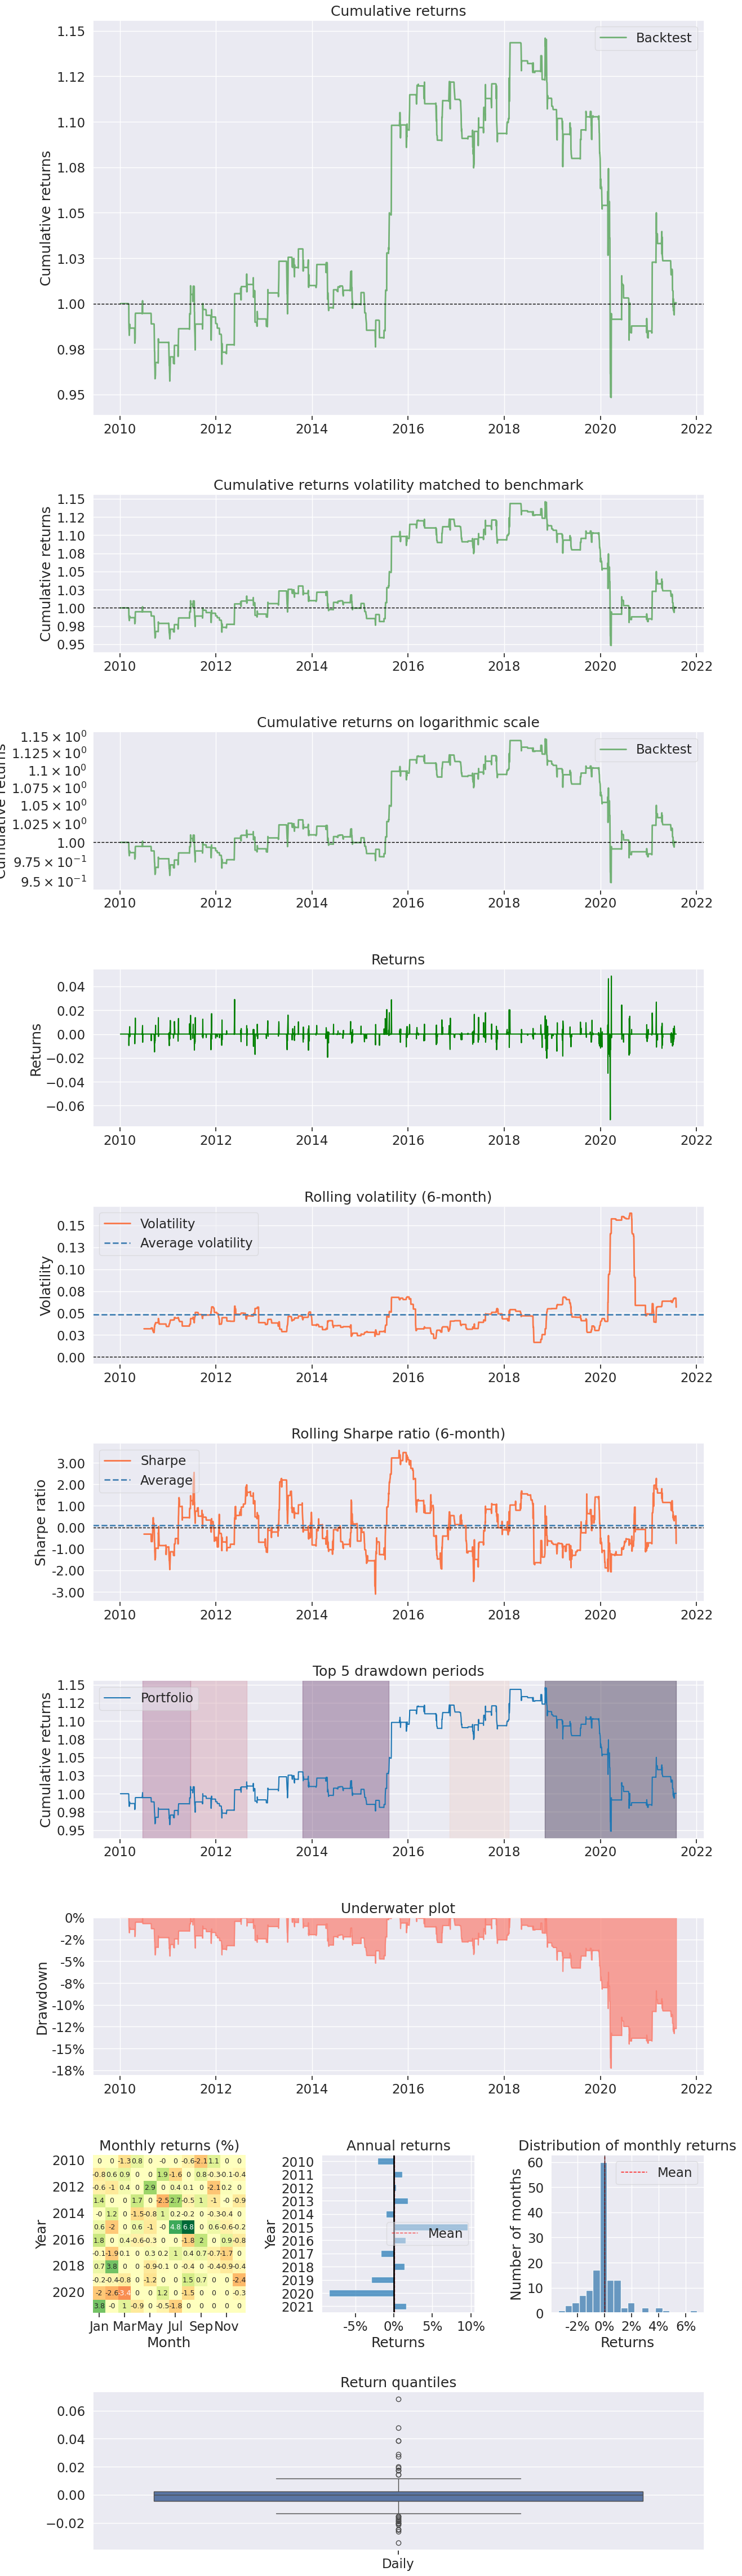

In [19]:
returns = result['returns']
pf.create_returns_tear_sheet(returns)

# Variable Initiallization for Multi Assets

In [20]:
bundle = 'snp100bundles'
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
# Set the start and end dates
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-07-31')
capital_base = 10_000
# calendar = get_calendar('XDSE')
symb = 'AAPL'
bollinger_window = 30
bollinger_dev = 2

# Zipline Functions

In [21]:
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.bollinger_window = bollinger_window  # Bollinger Bands window
    context.bollinger_dev = bollinger_dev  # Number of standard deviations for Bollinger Bands

def exec_trade(data, positions):
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

def handle_data(context, data):
    buy_signal = False
    sell_signal = False
    for asset in context.assets:
        # Get historical price data
        prices = data.history(asset, 'close', context.bollinger_window + 1, frequency='1d')
        # print(prices)
        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)
    
        # Get the current price
        current_price = data.current(asset, 'close')
    
        open_orders = get_open_orders()
        # Check if the asset is still tradable
        if data.can_trade(asset):
            # Generate signals based on Bollinger Bands
            if current_price > upper_band:
                order_target_percent(asset, -0.5)  # Short position
                buy_signal=True
            elif current_price < lower_band:
                order_target_percent(asset, 0.5)  # Long position
                sell_signal=True
            else:
                order_target_percent(asset, 0)  # Close position
        
        # Record the values for later analysis
        record(price=current_price, upper=upper_band, lower=lower_band)
        record(
            AAPL=current_price,
            lower_band=lower_band, upper_band=upper_band,
            sell_signal = sell_signal,
            buy_signal = buy_signal,
            price_hist=prices
        )

In [22]:
# Run the algorithm
result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='snp100bundles',
)

/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/zipline/data/data_portal.py:951: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


# Volitility, Sharpe Ratio and Portfolio Value

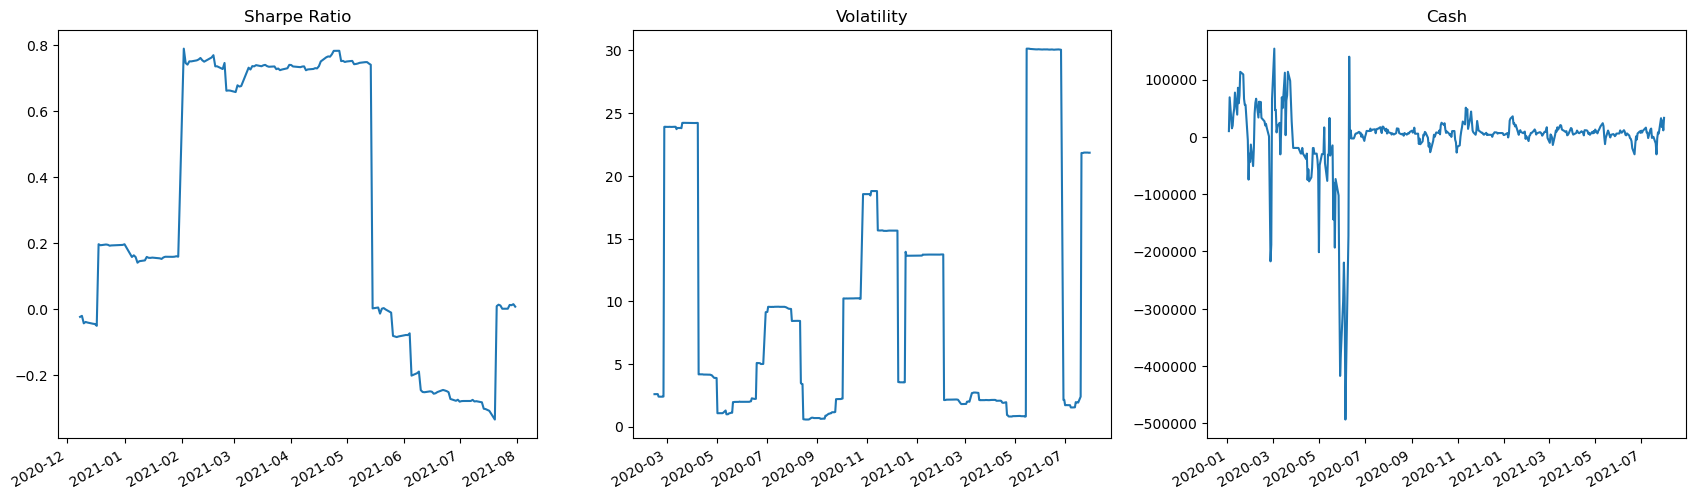

In [23]:
result["vols"] = result.starting_cash.pct_change().rolling(30).std()
def my_rolling_sharpe(ser):
    return np.sqrt(90) * (ser.mean()/ser.std())
result["sharpe_ratio"] = result['starting_cash'].pct_change().rolling(235).apply(my_rolling_sharpe)
fig, ax = plt.subplots(1, 3, figsize=(21,6))
result['sharpe_ratio'].plot(ax = ax[0], title='Sharpe Ratio')
result['vols'].plot(ax = ax[1], title='Volatility')
result['ending_cash'].plot(ax = ax[2], title='Cash')
plt.show()

/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/empyrical/stats.py:1380: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-100.0%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2020-01-02
End date,2021-07-30
Total months,18
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,1489.488%
Sharpe ratio,-18.36
Calmar ratio,-0.25
Stability,NaN
Max drawdown,-400.691%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,400.69,2020-05-27,2020-05-28,2020-05-29,3
1,395.43,2020-05-29,2020-06-01,2020-06-02,3
2,360.84,2020-05-22,2020-05-26,2020-05-27,4
3,325.84,2020-06-02,2020-06-03,2020-06-04,3
4,221.58,2020-01-02,2020-05-21,2020-05-22,101


/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:1373: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(
/home/mhmunem/.conda/envs/env_zipline/lib/python3.9/site-packages/pyfolio/plotting.py:1401: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


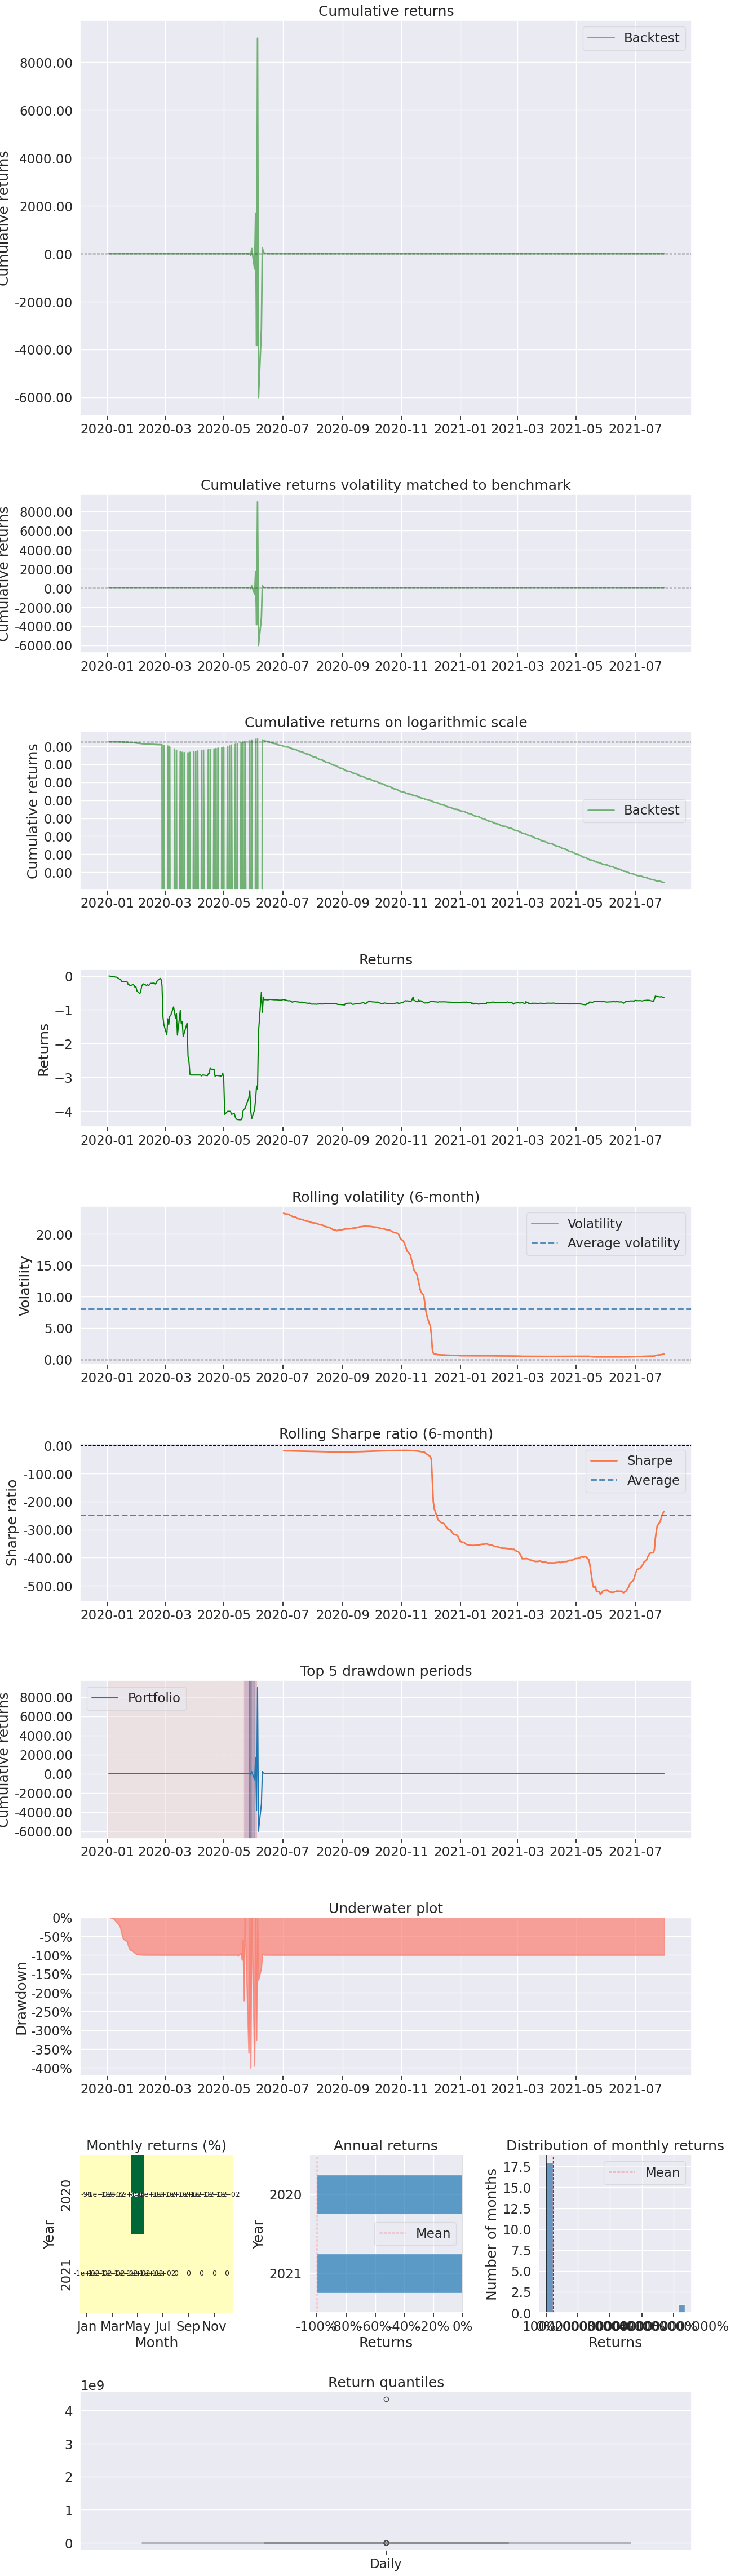

In [42]:
pf.create_returns_tear_sheet(returns=result.algorithm_period_return, benchmark_rets=None)

In [ ]:
def initialize(context):
    context.i = 0
    set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)

    # Initialize parameters for tuning
    context.best_sharpe = float('-inf')
    context.best_params = None

    # Define hyperparameter values for grid search
    bollinger_window_values = [10, 20, 30]
    bollinger_dev_values = [1.0, 2.0, 3.0]
    stop_loss_percent_values = [0.05, 0.1, 0.2]

    # Perform grid search
    for bollinger_window in bollinger_window_values:
        for bollinger_dev in bollinger_dev_values:
            for stop_loss_percent in stop_loss_percent_values:
                context.bollinger_window = bollinger_window
                context.bollinger_dev = bollinger_dev
                context.stop_loss_percent = stop_loss_percent

                # Call handle_data to simulate the strategy with the current parameters
                handle_data(context, get_data())

    # Set the best parameters for trading
    context.bollinger_window, context.bollinger_dev, context.stop_loss_percent = context.best_params

def handle_data(context, data):
    buy_signal = False
    sell_signal = False

    for asset in context.assets:
        # ... (existing strategy logic)

        # Calculate performance metric (e.g., Sharpe ratio)
        sharpe_ratio = calculate_sharpe_ratio(context)

        # Check if current parameters result in a better performance
        if sharpe_ratio > context.best_sharpe:
            context.best_sharpe = sharpe_ratio
            context.best_params = (context.bollinger_window, context.bollinger_dev, context.stop_loss_percent)

# Add the calculate_sharpe_ratio function here if needed
# def calculate_sharpe_ratio(context):
#     ...

# Assuming you have a function to retrieve historical data
def get_data():
    # Replace this with your logic to retrieve historical data
    # For simulation purposes, you can use random data or other sources
    return simulated_historical_data()

result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='multi_asset_snp100',
)
